# VGG

This notebook uses model "VGG16" to conduct regression of images.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [ ]:
# Dataset and model path
DATASET_PATH = "/home/ubuntu/Desktop/Ra/datasets/Ra_128_indexed.h5"
MODEL_PATH = "/home/ubuntu/Desktop/Ra/models/VGG16_128_regression.pth"
OUTPUT_PATH = "/home/ubuntu/Desktop/Ra/outputs/VGG16_128_regression.csv"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 200
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 10

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Path
if not os.path.exists(os.path.dirname(MODEL_PATH)):
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    print(f"Make new directory {os.path.dirname(MODEL_PATH)}")

Device: cuda


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images, and normalize the pixel values.

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Image standardization
mean = images.mean(dim=[0, 2, 3], keepdim=True)
std = images.std(dim=[0, 2, 3], keepdim=True)
images = (images - mean) / std

# Label normalization
labels = (labels - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)



Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)
print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([1839, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([1839])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [6]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/tmp/ipykernel_6381/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([1839, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([1839, 1])


/tmp/ipykernel_6381/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
/tmp/ipykernel_6381/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/tmp/ipykernel_6381/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Train

Start training for `epoch` loops, record the training losses and validation losses.

In [7]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(
    vgg16.classifier.parameters(), lr=LR, weight_decay=LR_WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

# Record the loss values
train_loss_list = []
val_loss_list = []

# Loop by epoch
for epoch in range(NUM_EPOCHS):

    # Train
    vgg16.train()
    train_loss = 0.0
    train_size = 0
    for batch_images, batch_labels in train_loader:
        # Load data
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # Pass loss value
        outputs = vgg16(batch_images)
        loss = criterion(outputs, batch_labels)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add to the total loss
        batch_size = batch_images.size(0)
        train_loss += loss.item() * batch_size
        train_size += batch_size

    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)

    # Validate
    vgg16.eval()
    val_loss = 0
    val_samples = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Load data
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            # Output
            outputs = vgg16(batch_images)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
            # Add to total loss
            batch_size = batch_images.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size
    val_loss /= val_samples
    val_loss_list.append(val_loss)

    # Print
    print(
        f"[Epoch {(epoch+1):d} / {(NUM_EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {val_loss:f} (MSE)] [Learning Rate: {optimizer.param_groups[0]['lr']}]"
    )

    # Scheduler
    scheduler.step(val_loss)

[Epoch 1 / 200] [Train Loss 2.620980 (MSE)] [Valid Loss 0.031355 (MSE)] [Learning Rate: 0.001]


[Epoch 2 / 200] [Train Loss 0.038906 (MSE)] [Valid Loss 0.018007 (MSE)] [Learning Rate: 0.001]


[Epoch 3 / 200] [Train Loss 0.033071 (MSE)] [Valid Loss 0.022276 (MSE)] [Learning Rate: 0.001]


[Epoch 4 / 200] [Train Loss 0.033171 (MSE)] [Valid Loss 0.014833 (MSE)] [Learning Rate: 0.001]


[Epoch 5 / 200] [Train Loss 0.030426 (MSE)] [Valid Loss 0.017528 (MSE)] [Learning Rate: 0.001]


[Epoch 6 / 200] [Train Loss 0.031164 (MSE)] [Valid Loss 0.011489 (MSE)] [Learning Rate: 0.001]


[Epoch 7 / 200] [Train Loss 0.032326 (MSE)] [Valid Loss 0.012983 (MSE)] [Learning Rate: 0.001]


[Epoch 8 / 200] [Train Loss 0.032449 (MSE)] [Valid Loss 0.012196 (MSE)] [Learning Rate: 0.001]


[Epoch 9 / 200] [Train Loss 0.034909 (MSE)] [Valid Loss 0.018085 (MSE)] [Learning Rate: 0.001]


[Epoch 10 / 200] [Train Loss 0.028242 (MSE)] [Valid Loss 0.018221 (MSE)] [Learning Rate: 0.001]


[Epoch 11 / 200] [Train Loss 0.064170 (MSE)] [Valid Loss 0.020117 (MSE)] [Learning Rate: 0.001]


[Epoch 12 / 200] [Train Loss 0.029368 (MSE)] [Valid Loss 0.011214 (MSE)] [Learning Rate: 0.001]


[Epoch 13 / 200] [Train Loss 0.030598 (MSE)] [Valid Loss 0.016715 (MSE)] [Learning Rate: 0.001]


[Epoch 14 / 200] [Train Loss 0.026287 (MSE)] [Valid Loss 0.030446 (MSE)] [Learning Rate: 0.001]


[Epoch 15 / 200] [Train Loss 0.023808 (MSE)] [Valid Loss 0.013384 (MSE)] [Learning Rate: 0.001]


[Epoch 16 / 200] [Train Loss 0.026030 (MSE)] [Valid Loss 0.015302 (MSE)] [Learning Rate: 0.001]


[Epoch 17 / 200] [Train Loss 0.029924 (MSE)] [Valid Loss 0.010681 (MSE)] [Learning Rate: 0.001]


[Epoch 18 / 200] [Train Loss 0.027121 (MSE)] [Valid Loss 0.008948 (MSE)] [Learning Rate: 0.001]


[Epoch 19 / 200] [Train Loss 0.021551 (MSE)] [Valid Loss 0.007852 (MSE)] [Learning Rate: 0.001]


[Epoch 20 / 200] [Train Loss 0.022469 (MSE)] [Valid Loss 0.008590 (MSE)] [Learning Rate: 0.001]


[Epoch 21 / 200] [Train Loss 0.021401 (MSE)] [Valid Loss 0.068374 (MSE)] [Learning Rate: 0.001]


[Epoch 22 / 200] [Train Loss 0.020791 (MSE)] [Valid Loss 0.008229 (MSE)] [Learning Rate: 0.001]


[Epoch 23 / 200] [Train Loss 0.039953 (MSE)] [Valid Loss 0.013044 (MSE)] [Learning Rate: 0.001]


[Epoch 24 / 200] [Train Loss 0.025482 (MSE)] [Valid Loss 0.017600 (MSE)] [Learning Rate: 0.001]


[Epoch 25 / 200] [Train Loss 0.028917 (MSE)] [Valid Loss 0.020379 (MSE)] [Learning Rate: 0.001]


[Epoch 26 / 200] [Train Loss 0.022040 (MSE)] [Valid Loss 0.010470 (MSE)] [Learning Rate: 0.0005]


[Epoch 27 / 200] [Train Loss 0.020393 (MSE)] [Valid Loss 0.010786 (MSE)] [Learning Rate: 0.0005]


[Epoch 28 / 200] [Train Loss 0.021434 (MSE)] [Valid Loss 0.010196 (MSE)] [Learning Rate: 0.0005]


[Epoch 29 / 200] [Train Loss 0.020146 (MSE)] [Valid Loss 0.008914 (MSE)] [Learning Rate: 0.0005]


[Epoch 30 / 200] [Train Loss 0.020629 (MSE)] [Valid Loss 0.012046 (MSE)] [Learning Rate: 0.0005]


[Epoch 31 / 200] [Train Loss 0.019722 (MSE)] [Valid Loss 0.009915 (MSE)] [Learning Rate: 0.0005]


[Epoch 32 / 200] [Train Loss 0.018869 (MSE)] [Valid Loss 0.008178 (MSE)] [Learning Rate: 0.00025]


[Epoch 33 / 200] [Train Loss 0.018550 (MSE)] [Valid Loss 0.009933 (MSE)] [Learning Rate: 0.00025]


[Epoch 34 / 200] [Train Loss 0.018260 (MSE)] [Valid Loss 0.008211 (MSE)] [Learning Rate: 0.00025]


[Epoch 35 / 200] [Train Loss 0.018406 (MSE)] [Valid Loss 0.009312 (MSE)] [Learning Rate: 0.00025]


[Epoch 36 / 200] [Train Loss 0.018048 (MSE)] [Valid Loss 0.007327 (MSE)] [Learning Rate: 0.00025]


[Epoch 37 / 200] [Train Loss 0.016930 (MSE)] [Valid Loss 0.008404 (MSE)] [Learning Rate: 0.00025]


[Epoch 38 / 200] [Train Loss 0.017622 (MSE)] [Valid Loss 0.007516 (MSE)] [Learning Rate: 0.00025]


[Epoch 39 / 200] [Train Loss 0.016921 (MSE)] [Valid Loss 0.009583 (MSE)] [Learning Rate: 0.00025]


[Epoch 40 / 200] [Train Loss 0.016655 (MSE)] [Valid Loss 0.009481 (MSE)] [Learning Rate: 0.00025]


[Epoch 41 / 200] [Train Loss 0.017297 (MSE)] [Valid Loss 0.009675 (MSE)] [Learning Rate: 0.00025]


[Epoch 42 / 200] [Train Loss 0.016866 (MSE)] [Valid Loss 0.008714 (MSE)] [Learning Rate: 0.00025]


[Epoch 43 / 200] [Train Loss 0.016286 (MSE)] [Valid Loss 0.009551 (MSE)] [Learning Rate: 0.000125]


[Epoch 44 / 200] [Train Loss 0.016392 (MSE)] [Valid Loss 0.007794 (MSE)] [Learning Rate: 0.000125]


[Epoch 45 / 200] [Train Loss 0.015461 (MSE)] [Valid Loss 0.008101 (MSE)] [Learning Rate: 0.000125]


[Epoch 46 / 200] [Train Loss 0.016084 (MSE)] [Valid Loss 0.008164 (MSE)] [Learning Rate: 0.000125]


[Epoch 47 / 200] [Train Loss 0.015611 (MSE)] [Valid Loss 0.008687 (MSE)] [Learning Rate: 0.000125]


[Epoch 48 / 200] [Train Loss 0.014985 (MSE)] [Valid Loss 0.006595 (MSE)] [Learning Rate: 0.000125]


[Epoch 49 / 200] [Train Loss 0.015171 (MSE)] [Valid Loss 0.006685 (MSE)] [Learning Rate: 0.000125]


[Epoch 50 / 200] [Train Loss 0.015062 (MSE)] [Valid Loss 0.007154 (MSE)] [Learning Rate: 0.000125]


[Epoch 51 / 200] [Train Loss 0.014835 (MSE)] [Valid Loss 0.007102 (MSE)] [Learning Rate: 0.000125]


[Epoch 52 / 200] [Train Loss 0.014810 (MSE)] [Valid Loss 0.006865 (MSE)] [Learning Rate: 0.000125]


[Epoch 53 / 200] [Train Loss 0.014251 (MSE)] [Valid Loss 0.007023 (MSE)] [Learning Rate: 0.000125]


[Epoch 54 / 200] [Train Loss 0.014063 (MSE)] [Valid Loss 0.006691 (MSE)] [Learning Rate: 0.000125]


[Epoch 55 / 200] [Train Loss 0.013779 (MSE)] [Valid Loss 0.008348 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 56 / 200] [Train Loss 0.013847 (MSE)] [Valid Loss 0.006795 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 57 / 200] [Train Loss 0.013969 (MSE)] [Valid Loss 0.007140 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 58 / 200] [Train Loss 0.013344 (MSE)] [Valid Loss 0.007060 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 59 / 200] [Train Loss 0.013326 (MSE)] [Valid Loss 0.005983 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 60 / 200] [Train Loss 0.014264 (MSE)] [Valid Loss 0.006823 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 61 / 200] [Train Loss 0.013590 (MSE)] [Valid Loss 0.007018 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 62 / 200] [Train Loss 0.013409 (MSE)] [Valid Loss 0.006324 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 63 / 200] [Train Loss 0.012890 (MSE)] [Valid Loss 0.007344 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 64 / 200] [Train Loss 0.013596 (MSE)] [Valid Loss 0.005705 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 65 / 200] [Train Loss 0.012970 (MSE)] [Valid Loss 0.006852 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 66 / 200] [Train Loss 0.013797 (MSE)] [Valid Loss 0.007566 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 67 / 200] [Train Loss 0.013290 (MSE)] [Valid Loss 0.005776 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 68 / 200] [Train Loss 0.013225 (MSE)] [Valid Loss 0.005812 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 69 / 200] [Train Loss 0.014037 (MSE)] [Valid Loss 0.005660 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 70 / 200] [Train Loss 0.012536 (MSE)] [Valid Loss 0.006263 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 71 / 200] [Train Loss 0.012781 (MSE)] [Valid Loss 0.006729 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 72 / 200] [Train Loss 0.013261 (MSE)] [Valid Loss 0.006581 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 73 / 200] [Train Loss 0.012585 (MSE)] [Valid Loss 0.006060 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 74 / 200] [Train Loss 0.012487 (MSE)] [Valid Loss 0.005391 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 75 / 200] [Train Loss 0.011926 (MSE)] [Valid Loss 0.005122 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 76 / 200] [Train Loss 0.011880 (MSE)] [Valid Loss 0.006502 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 77 / 200] [Train Loss 0.010902 (MSE)] [Valid Loss 0.005329 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 78 / 200] [Train Loss 0.010693 (MSE)] [Valid Loss 0.005719 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 79 / 200] [Train Loss 0.010603 (MSE)] [Valid Loss 0.005160 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 80 / 200] [Train Loss 0.010573 (MSE)] [Valid Loss 0.006200 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 81 / 200] [Train Loss 0.010753 (MSE)] [Valid Loss 0.005146 (MSE)] [Learning Rate: 6.25e-05]


[Epoch 82 / 200] [Train Loss 0.009923 (MSE)] [Valid Loss 0.006008 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 83 / 200] [Train Loss 0.009988 (MSE)] [Valid Loss 0.005321 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 84 / 200] [Train Loss 0.009620 (MSE)] [Valid Loss 0.004771 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 85 / 200] [Train Loss 0.009588 (MSE)] [Valid Loss 0.004587 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 86 / 200] [Train Loss 0.009312 (MSE)] [Valid Loss 0.004494 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 87 / 200] [Train Loss 0.008757 (MSE)] [Valid Loss 0.004636 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 88 / 200] [Train Loss 0.008768 (MSE)] [Valid Loss 0.004730 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 89 / 200] [Train Loss 0.008399 (MSE)] [Valid Loss 0.005048 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 90 / 200] [Train Loss 0.008490 (MSE)] [Valid Loss 0.004102 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 91 / 200] [Train Loss 0.008085 (MSE)] [Valid Loss 0.004170 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 92 / 200] [Train Loss 0.007857 (MSE)] [Valid Loss 0.003873 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 93 / 200] [Train Loss 0.008137 (MSE)] [Valid Loss 0.004860 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 94 / 200] [Train Loss 0.008084 (MSE)] [Valid Loss 0.003910 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 95 / 200] [Train Loss 0.007654 (MSE)] [Valid Loss 0.004112 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 96 / 200] [Train Loss 0.007797 (MSE)] [Valid Loss 0.003986 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 97 / 200] [Train Loss 0.007507 (MSE)] [Valid Loss 0.004084 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 98 / 200] [Train Loss 0.007275 (MSE)] [Valid Loss 0.003758 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 99 / 200] [Train Loss 0.007259 (MSE)] [Valid Loss 0.003801 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 100 / 200] [Train Loss 0.007183 (MSE)] [Valid Loss 0.004240 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 101 / 200] [Train Loss 0.007052 (MSE)] [Valid Loss 0.004052 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 102 / 200] [Train Loss 0.007139 (MSE)] [Valid Loss 0.004514 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 103 / 200] [Train Loss 0.006681 (MSE)] [Valid Loss 0.003630 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 104 / 200] [Train Loss 0.006559 (MSE)] [Valid Loss 0.003690 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 105 / 200] [Train Loss 0.006668 (MSE)] [Valid Loss 0.004389 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 106 / 200] [Train Loss 0.006577 (MSE)] [Valid Loss 0.003567 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 107 / 200] [Train Loss 0.006485 (MSE)] [Valid Loss 0.004054 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 108 / 200] [Train Loss 0.006180 (MSE)] [Valid Loss 0.003837 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 109 / 200] [Train Loss 0.006240 (MSE)] [Valid Loss 0.003499 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 110 / 200] [Train Loss 0.005903 (MSE)] [Valid Loss 0.003805 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 111 / 200] [Train Loss 0.005866 (MSE)] [Valid Loss 0.003893 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 112 / 200] [Train Loss 0.005658 (MSE)] [Valid Loss 0.003702 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 113 / 200] [Train Loss 0.005810 (MSE)] [Valid Loss 0.003173 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 114 / 200] [Train Loss 0.005596 (MSE)] [Valid Loss 0.003163 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 115 / 200] [Train Loss 0.005288 (MSE)] [Valid Loss 0.003038 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 116 / 200] [Train Loss 0.005137 (MSE)] [Valid Loss 0.002991 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 117 / 200] [Train Loss 0.005268 (MSE)] [Valid Loss 0.003698 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 118 / 200] [Train Loss 0.004898 (MSE)] [Valid Loss 0.003498 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 119 / 200] [Train Loss 0.005081 (MSE)] [Valid Loss 0.003082 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 120 / 200] [Train Loss 0.004765 (MSE)] [Valid Loss 0.002720 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 121 / 200] [Train Loss 0.004503 (MSE)] [Valid Loss 0.002725 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 122 / 200] [Train Loss 0.004372 (MSE)] [Valid Loss 0.002627 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 123 / 200] [Train Loss 0.004212 (MSE)] [Valid Loss 0.002828 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 124 / 200] [Train Loss 0.004164 (MSE)] [Valid Loss 0.002662 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 125 / 200] [Train Loss 0.003901 (MSE)] [Valid Loss 0.002889 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 126 / 200] [Train Loss 0.003789 (MSE)] [Valid Loss 0.002658 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 127 / 200] [Train Loss 0.003622 (MSE)] [Valid Loss 0.002673 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 128 / 200] [Train Loss 0.003554 (MSE)] [Valid Loss 0.002541 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 129 / 200] [Train Loss 0.003364 (MSE)] [Valid Loss 0.002525 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 130 / 200] [Train Loss 0.003437 (MSE)] [Valid Loss 0.002558 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 131 / 200] [Train Loss 0.003242 (MSE)] [Valid Loss 0.002601 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 132 / 200] [Train Loss 0.003071 (MSE)] [Valid Loss 0.002925 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 133 / 200] [Train Loss 0.003179 (MSE)] [Valid Loss 0.002873 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 134 / 200] [Train Loss 0.002996 (MSE)] [Valid Loss 0.002749 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 135 / 200] [Train Loss 0.002945 (MSE)] [Valid Loss 0.002202 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 136 / 200] [Train Loss 0.002945 (MSE)] [Valid Loss 0.002624 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 137 / 200] [Train Loss 0.002913 (MSE)] [Valid Loss 0.002345 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 138 / 200] [Train Loss 0.002789 (MSE)] [Valid Loss 0.002131 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 139 / 200] [Train Loss 0.002796 (MSE)] [Valid Loss 0.002379 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 140 / 200] [Train Loss 0.002638 (MSE)] [Valid Loss 0.002214 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 141 / 200] [Train Loss 0.002623 (MSE)] [Valid Loss 0.002376 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 142 / 200] [Train Loss 0.002508 (MSE)] [Valid Loss 0.002248 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 143 / 200] [Train Loss 0.002520 (MSE)] [Valid Loss 0.002524 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 144 / 200] [Train Loss 0.002527 (MSE)] [Valid Loss 0.002320 (MSE)] [Learning Rate: 3.125e-05]


[Epoch 145 / 200] [Train Loss 0.002101 (MSE)] [Valid Loss 0.002485 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 146 / 200] [Train Loss 0.002194 (MSE)] [Valid Loss 0.002161 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 147 / 200] [Train Loss 0.002054 (MSE)] [Valid Loss 0.002242 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 148 / 200] [Train Loss 0.002069 (MSE)] [Valid Loss 0.002148 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 149 / 200] [Train Loss 0.001940 (MSE)] [Valid Loss 0.002128 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 150 / 200] [Train Loss 0.001968 (MSE)] [Valid Loss 0.002083 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 151 / 200] [Train Loss 0.002010 (MSE)] [Valid Loss 0.002058 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 152 / 200] [Train Loss 0.001905 (MSE)] [Valid Loss 0.002016 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 153 / 200] [Train Loss 0.001909 (MSE)] [Valid Loss 0.002032 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 154 / 200] [Train Loss 0.001859 (MSE)] [Valid Loss 0.002093 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 155 / 200] [Train Loss 0.001969 (MSE)] [Valid Loss 0.002261 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 156 / 200] [Train Loss 0.001877 (MSE)] [Valid Loss 0.002121 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 157 / 200] [Train Loss 0.001842 (MSE)] [Valid Loss 0.002072 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 158 / 200] [Train Loss 0.001827 (MSE)] [Valid Loss 0.002153 (MSE)] [Learning Rate: 1.5625e-05]


[Epoch 159 / 200] [Train Loss 0.001720 (MSE)] [Valid Loss 0.001899 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 160 / 200] [Train Loss 0.001732 (MSE)] [Valid Loss 0.001924 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 161 / 200] [Train Loss 0.001692 (MSE)] [Valid Loss 0.001825 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 162 / 200] [Train Loss 0.001576 (MSE)] [Valid Loss 0.001766 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 163 / 200] [Train Loss 0.001570 (MSE)] [Valid Loss 0.001859 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 164 / 200] [Train Loss 0.001568 (MSE)] [Valid Loss 0.001835 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 165 / 200] [Train Loss 0.001581 (MSE)] [Valid Loss 0.001847 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 166 / 200] [Train Loss 0.001617 (MSE)] [Valid Loss 0.001829 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 167 / 200] [Train Loss 0.001622 (MSE)] [Valid Loss 0.001810 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 168 / 200] [Train Loss 0.001594 (MSE)] [Valid Loss 0.001800 (MSE)] [Learning Rate: 7.8125e-06]


[Epoch 169 / 200] [Train Loss 0.001486 (MSE)] [Valid Loss 0.001766 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 170 / 200] [Train Loss 0.001443 (MSE)] [Valid Loss 0.001798 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 171 / 200] [Train Loss 0.001455 (MSE)] [Valid Loss 0.001726 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 172 / 200] [Train Loss 0.001436 (MSE)] [Valid Loss 0.001735 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 173 / 200] [Train Loss 0.001409 (MSE)] [Valid Loss 0.001740 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 174 / 200] [Train Loss 0.001375 (MSE)] [Valid Loss 0.001722 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 175 / 200] [Train Loss 0.001417 (MSE)] [Valid Loss 0.001781 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 176 / 200] [Train Loss 0.001403 (MSE)] [Valid Loss 0.001797 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 177 / 200] [Train Loss 0.001384 (MSE)] [Valid Loss 0.001701 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 178 / 200] [Train Loss 0.001440 (MSE)] [Valid Loss 0.001800 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 179 / 200] [Train Loss 0.001405 (MSE)] [Valid Loss 0.001737 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 180 / 200] [Train Loss 0.001364 (MSE)] [Valid Loss 0.001799 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 181 / 200] [Train Loss 0.001388 (MSE)] [Valid Loss 0.001827 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 182 / 200] [Train Loss 0.001330 (MSE)] [Valid Loss 0.001731 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 183 / 200] [Train Loss 0.001364 (MSE)] [Valid Loss 0.001731 (MSE)] [Learning Rate: 3.90625e-06]


[Epoch 184 / 200] [Train Loss 0.001308 (MSE)] [Valid Loss 0.001795 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 185 / 200] [Train Loss 0.001342 (MSE)] [Valid Loss 0.001706 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 186 / 200] [Train Loss 0.001363 (MSE)] [Valid Loss 0.001713 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 187 / 200] [Train Loss 0.001288 (MSE)] [Valid Loss 0.001746 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 188 / 200] [Train Loss 0.001338 (MSE)] [Valid Loss 0.001693 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 189 / 200] [Train Loss 0.001241 (MSE)] [Valid Loss 0.001713 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 190 / 200] [Train Loss 0.001313 (MSE)] [Valid Loss 0.001748 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 191 / 200] [Train Loss 0.001317 (MSE)] [Valid Loss 0.001680 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 192 / 200] [Train Loss 0.001295 (MSE)] [Valid Loss 0.001694 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 193 / 200] [Train Loss 0.001318 (MSE)] [Valid Loss 0.001725 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 194 / 200] [Train Loss 0.001340 (MSE)] [Valid Loss 0.001748 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 195 / 200] [Train Loss 0.001319 (MSE)] [Valid Loss 0.001733 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 196 / 200] [Train Loss 0.001286 (MSE)] [Valid Loss 0.001717 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 197 / 200] [Train Loss 0.001265 (MSE)] [Valid Loss 0.001732 (MSE)] [Learning Rate: 1.953125e-06]


[Epoch 198 / 200] [Train Loss 0.001270 (MSE)] [Valid Loss 0.001705 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 199 / 200] [Train Loss 0.001190 (MSE)] [Valid Loss 0.001667 (MSE)] [Learning Rate: 9.765625e-07]


[Epoch 200 / 200] [Train Loss 0.001234 (MSE)] [Valid Loss 0.001667 (MSE)] [Learning Rate: 9.765625e-07]


Then we plot the graphs of `train_loss_list` and `val_loss_lost`.

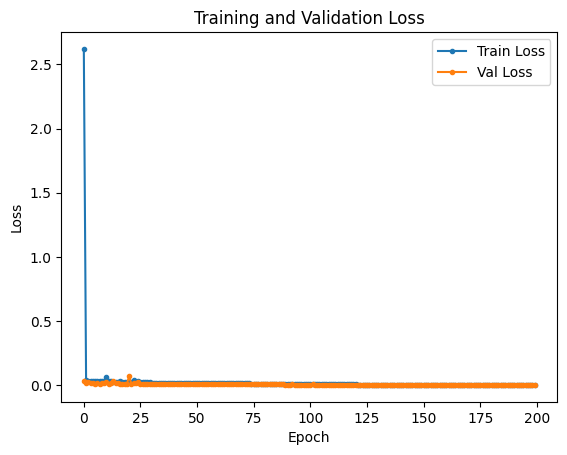

In [8]:
x = list(range(NUM_EPOCHS))
plt.plot(x, train_loss_list, label="Train Loss", marker=".")
plt.plot(x, val_loss_list, label="Val Loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Step 4 - Save / load the model

After training, we need to save the models.

In [9]:
# Save the trained model to disk
torch.save(vgg16.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /home/ubuntu/Desktop/Ra/models/VGG_128_regression.pth


To read the saved data, we can run the following codes:

In [10]:
# # Load the trained model weights
# vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# vgg16.eval()
# print("Model loaded from", MODEL_PATH)

## Exceptional test

Let's see if the model works well.

Model loaded from /home/ubuntu/Desktop/Ra/models/VGG_128_regression.pth


      Real Labels  Predicted Labels      Diff      MAPE
0           1.746          1.737595 -0.008405  0.995186
1           2.695          3.010450  0.315450  0.882950
2           1.816          2.055939  0.239939  0.867875
3           2.354          2.415876  0.061876  0.973714
4           3.901          3.885176 -0.015824  0.995944
...           ...               ...       ...       ...
1834        2.051          2.058516  0.007516  0.996336
1835        1.757          1.682156 -0.074844  0.957402
1836        2.593          2.941000  0.348000  0.865792
1837        4.092          4.103238  0.011238  0.997254
1838        2.040          1.938146 -0.101854  0.950071

[1839 rows x 4 columns]
MAPE: 0.9566445001014806


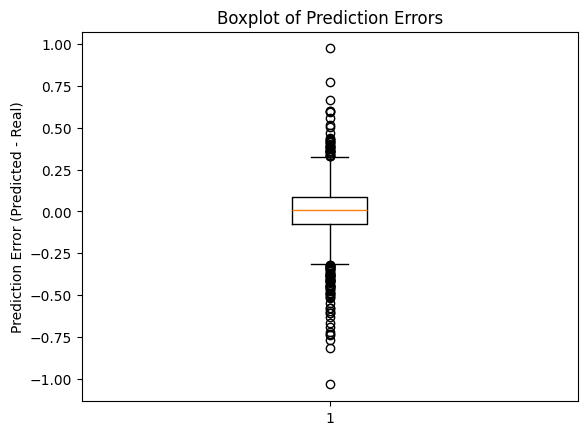

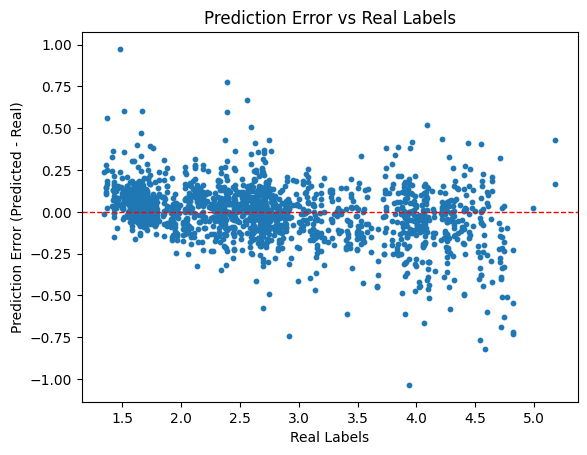

In [11]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = vgg16(images_val_tensor.to(device)).cpu().detach().numpy()

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()